In [48]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation_modify import *

<IPython.core.display.Javascript object>


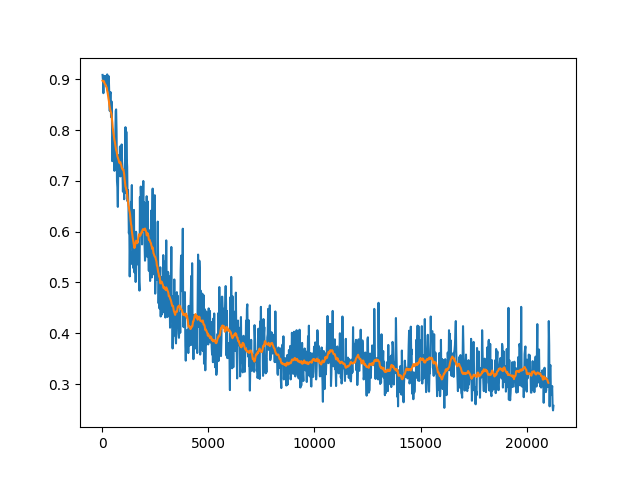

21020 0.30236000776290894 1051
12060 0.3524000000953674


In [49]:
# data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 6e-4
patience = 13
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 25
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

In [50]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
left_tail_size = 0
period = 20
start_point = 5
num_samples = 1000
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 50

'''
result list
'''
all_preds = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
all_errs = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
all_steps = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}


In [51]:
'''
power_regression
'''
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power regression'] = preds
all_errs['Power regression'] = errs
all_steps['Power regression'] = steps

100
Predicted Stopping epoch is 788.3. a = 0.9225461555964446, b = -0.007104045039831625, c = 0.02728222411192451, d^2=0
500
Predicted Stopping epoch is 7541.88. a = 1.0572761657516017, b = -0.03536971449916946, c = 11.945840036980075, d^2=0
900
Predicted Stopping epoch is 19528.02. a = 1.341500308984799, b = -0.08370765147492248, c = 15.792242485273738, d^2=0
1300
Predicted Stopping epoch is 27003.96. a = 1.458823153197642, b = -0.10069112159396867, c = 10.660505650132384, d^2=0
1700
Predicted Stopping epoch is 36627.26726726727. a = 2.2114985834856453, b = -0.16824539159888113, c = 61.19982378880884, d^2=0
2100
Predicted Stopping epoch is 37024.34434434435. a = 2.2374945155653876, b = -0.17013410627939873, c = 65.39505765417863, d^2=0
2500
Predicted Stopping epoch is 32297.84. a = 2.3914464909262136, b = -0.18021059875898868, c = 72.49864104804234, d^2=0
2900
Predicted Stopping epoch is 32274.82. a = 2.6578181342197844, b = -0.19652713140877334, c = 90.04441891087997, d^2=0
3300
Pred

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/indicator_simulation_modify.py:201: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps + x[2])+np.log(x[0]))), 2))


Predicted Stopping epoch is 25089.16. a = 2.6555289036318754, b = -0.20831748651226742, c = 23.50668323317728, d^2=0
6500
Predicted Stopping epoch is 25148.94. a = 2.722867714388914, b = -0.21241350774650863, c = 12.79613216096052, d^2=0
6900
Predicted Stopping epoch is 22167.68. a = 2.7401967954278192, b = -0.2138918923536197, c = 10.487513724669638, d^2=0
7300
Predicted Stopping epoch is 15382.08. a = 2.6403500258129284, b = -0.20869854004404112, c = 45.985654995283525, d^2=0
7700
Predicted Stopping epoch is 18403.92. a = 2.79491872592764, b = -0.21750794897941206, c = 15.1356242079759, d^2=0
8100
Predicted Stopping epoch is 18513.0. a = 4.56580643226263, b = -0.2777388690170507, c = 125.21797959138699, d^2=0
8500
Predicted Stopping epoch is 15470.04. a = 3.2659169712747373, b = -0.23752266100772848, c = 35.14482955263828, d^2=0
8900
Predicted Stopping epoch is 12651.72. a = 2.2848970826705264, b = -0.1936073758500113, c = -0.025469951055289087, d^2=0
9300
Predicted Stopping epoch is

In [52]:
'''
power + linear regression
'''
bnds = ((0, None), (None, 0), (None, None),(None,None))
inits = (1,0,0,1)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power + linear regression'] = preds
all_errs['Power + linear regression'] = errs
all_steps['Power + linear regression'] = steps

100
Predicted Stopping epoch is 400.0. a = 1.0030822408519502, b = -0.03415679471194352, c = 1.001326875893089, d^2=0.0005248409126564419
500
Predicted Stopping epoch is 7371.82. a = 1.033399954951788, b = -0.03158520872823381, c = 2.5999672111823084, d^2=7.301094541370851e-10
900
Predicted Stopping epoch is 18737.06. a = 1.2928054839251595, b = -0.07739183441985924, c = 12.156360374903805, d^2=7.658836146849755e-07
1300
Predicted Stopping epoch is 27181.46. a = 1.3969858340930807, b = -0.09421765465176346, c = 1.5572403543430338, d^2=1.447834309927396e-09
1700
Predicted Stopping epoch is 37903.46. a = 1.6068353872552803, b = -0.12109261272719009, c = 20.996697677113907, d^2=1.531227185446408e-09
2100
Predicted Stopping epoch is 35811.08. a = 2.1645491463079143, b = -0.165603562488765, c = 55.73209916516822, d^2=1.1752118840406327e-08
2500
Predicted Stopping epoch is 33602.56. a = 2.225740115666661, b = -0.1713647530732629, c = 37.102771700307194, d^2=1.743135840670571e-08
2900
Predict

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/indicator_simulation_modify.py:209: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps + x[3])+np.log(x[0]))+x[2]**2*(steps-steps[0])),2))


Predicted Stopping epoch is 20844.3. a = 2.1250948805612064, b = -0.1714945268652451, c = 20.74738753798733, d^2=2.0114921388773582e-11
4100
Predicted Stopping epoch is 28507.46. a = 2.3180478198542747, b = -0.18494200089117574, c = 21.25845472487779, d^2=4.7353867513486046e-07
4500
Predicted Stopping epoch is 27535.9. a = 2.544486050861569, b = -0.1994668770102574, c = 20.43245497542811, d^2=1.0683668925029076e-13
4900
Predicted Stopping epoch is 29635.98. a = 2.5308560269250235, b = -0.19954717110685766, c = 16.14215365350946, d^2=4.776987011859942e-09
5300
Predicted Stopping epoch is 23119.4. a = 2.6857002257607396, b = -0.20879319127974574, c = 15.813432031858452, d^2=1.5392721695712796e-11
5700
Predicted Stopping epoch is 21202.96. a = 2.7036728513122226, b = -0.2100073463650396, c = 24.802467216338236, d^2=8.455782974195816e-09
6100
Predicted Stopping epoch is 24653.72. a = 2.876020849078185, b = -0.2190010459818941, c = 21.088209372654834, d^2=4.005313721792616e-09
6500
Predicte

In [53]:
KF_start_point = 80
report_period = 20
init_d = 0
var_ud = 1e-6
noise_est_win_size = 300

preds, CIs, steps = mixKFIndicator(
                            earlyStoppingStep,
                            val_err,
                            smooth_win_size,
                             num_epochs_between_eval, 
                             min_delta,
                             patience,
                            report_period,
                            pred_win_size = pred_win_size,
                            period = period,
                            init_d = init_d,
                            var_ud = var_ud,
                            start_point = start_point,
                            KF_start_point = KF_start_point,
                            num_samples=num_samples,
                            upper_limit=upper_limit,
                            noise_est_win_size=noise_est_win_size)

print(len(preds))
errs = CIs2errs(CIs)
all_preds['Kalman filtering'] = preds
all_errs['Kalman filtering'] = errs
all_steps['Kalman filtering'] = steps

100
Predicted Stopping epoch is 759.06. a = 0.9225461555964446, b = -0.007104045039831625, c = 0.02728222411192451, d^2=0
500
Predicted Stopping epoch is 7584.4. a = 1.0572761657516017, b = -0.03536971449916946, c = 11.945840036980075, d^2=0
900
Predicted Stopping epoch is 19991.02. a = 1.341500308984799, b = -0.08370765147492248, c = 15.792242485273738, d^2=0
1300
Predicted Stopping epoch is 26862.9. a = 1.458823153197642, b = -0.10069112159396867, c = 10.660505650132384, d^2=0
1700
Predicted Stopping epoch is 39074.84. a = 2.2114985834856453, b = -0.16824539159888113, c = 61.19982378880884, d^2=0
Kalman filtering starts
Global Step: 2000
Predicted early stopping epoch: 44134.95477386934. d^2 = 1.31516317757414e-07
Global Step: 2400
Predicted early stopping epoch: 42318.67602808425. d^2 = 1.374082932902099e-07
Global Step: 2800
Predicted early stopping epoch: 40958.65731462926. d^2 = 1.2630588879333784e-07
Global Step: 3200
Predicted early stopping epoch: 39993.76753507014. d^2 = 1.26

<IPython.core.display.Javascript object>


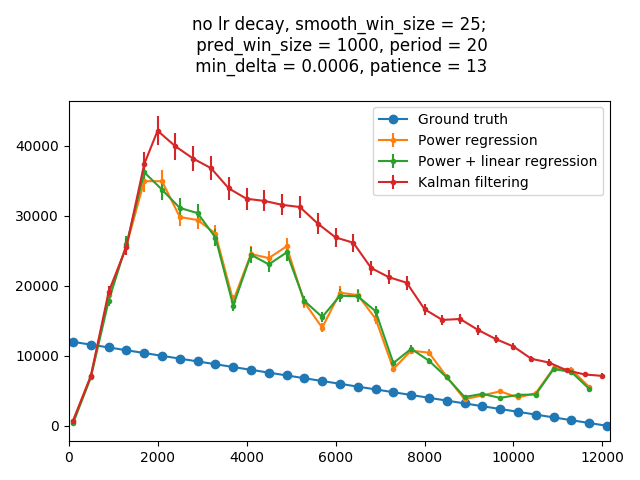

In [54]:
fig = plt.figure()

# ground truth
x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.plot(x, earlyStoppingStep-x,'-o')
legend = ['Ground truth']

# three methods
for alg in all_preds:
    plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    legend.append(alg)
    
plt.xlim(0,earlyStoppingStep+100)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# # save the image
# dir_ = '/Users/stranot/Desktop/resutls122318/cifar_subset_bs_32/'
# plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# # store the results
# for key in all_preds:
#     all_preds[key] = list(all_preds[key])
#     all_errs[key] = list(all_errs[key])
#     all_steps[key] = list(all_steps[key])
# output = {}
# output['all_preds'] = all_preds
# output['all_errs'] = all_errs
# output['all_steps'] = all_steps
# with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
#     json.dump(output, f)